In [1]:
%pip install pyodbc  
%pip install python-dotenv


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyodbc
from dotenv import dotenv_values 

# Analysis libraries
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
import re
import datetime
from datetime import datetime


# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prettytable import PrettyTable
# Warning libraries
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [5]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)
df1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [6]:
df2=pd.read_csv("data/LP2_Telco-churn-last-2000.csv.")
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [7]:
print(f'dataset_1: {df1.columns}\n\n\
        dataset_2: {df2.columns}')

dataset_1: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

        dataset_2: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [8]:
# You can concatenate this with other DataFrames to get one data set for your work
train=pd.concat([df1,df2])
train.to_csv('train.csv',index=False)
train=pd.read_csv("train.csv",index_col=0)
train.sample(20)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
4512-ZUIYL,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),70.000000,153.05,Yes
0516-UXRMT,Female,0,False,False,62,True,True,Fiber optic,True,True,True,False,False,False,One year,True,Electronic check,92.050003,5755.7998046875,False
5366-IJEQJ,Male,0,No,No,20,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,88.700000,1761.45,Yes
8111-SLLHI,Male,1,True,False,39,True,True,Fiber optic,False,True,True,False,True,True,Month-to-month,True,Electronic check,105.650002,4284.7998046875,True
1113-IUJYX,Female,0,Yes,No,14,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,One year,No,Mailed check,105.950000,1348.9,Yes
0870-VEMYL,Female,0,No,No,5,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Credit card (automatic),53.850000,259.8,Yes
8150-QUDFX,Male,0,False,False,2,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,False,Mailed check,19.850000,51.599998474121094,False
5975-BAICR,Male,0,Yes,Yes,36,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,Yes,Credit card (automatic),63.700000,2188.5,No
4188-FRABG,Male,0,Yes,No,57,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,103.050000,5925.75,No


In [9]:
#Preview the data
print(train.shape,"\n")
print(train.info())

(5043, 20) 

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   int64  
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     4774 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    4392 non-null   object 
 9   OnlineBackup      4392 non-null   object 
 10  DeviceProtection  4392 non-null   object 
 11  TechSupport       4392 non-null   object 
 12  StreamingTV       4392 non-null   object 
 13  StreamingMovies   4392 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5

In [10]:
#defining a function that returns counts of unique values
def value(column):
    return train[column].value_counts() 

In [11]:
#for col in train.columns:
    #print(f"Unique values of {col} are {train[col].unique()}"/n)

In [12]:
value("gender")

Male      2559
Female    2484
Name: gender, dtype: int64

In [13]:
value("SeniorCitizen")

0    4224
1     819
Name: SeniorCitizen, dtype: int64

In [14]:
value("Partner")

False    1538
True     1462
No       1047
Yes       996
Name: Partner, dtype: int64

In [15]:
value("Dependents")

False    2070
No       1412
True      930
Yes       631
Name: Dependents, dtype: int64

In [16]:
value("tenure")

1     434
72    257
2     167
3     144
71    124
     ... 
39     40
28     39
44     36
36     34
0       8
Name: tenure, Length: 73, dtype: int64

In [17]:
value("PhoneService")

True     2731
Yes      1823
False     269
No        220
Name: PhoneService, dtype: int64

In [18]:
value("MultipleLines")

False               1437
True                1294
No                   987
Yes                  836
No phone service     220
Name: MultipleLines, dtype: int64

In [19]:
value("InternetService")

Fiber optic    2248
DSL            1715
No             1080
Name: InternetService, dtype: int64

In [20]:
value("OnlineSecurity")

False                  1478
No                     1029
True                    871
Yes                     585
No internet service     429
Name: OnlineSecurity, dtype: int64

In [21]:
value("OnlineBackup")

False                  1320
True                   1029
No                      911
Yes                     703
No internet service     429
Name: OnlineBackup, dtype: int64

In [22]:
value("DeviceProtection")

False                  1296
True                   1053
No                      923
Yes                     691
No internet service     429
Name: DeviceProtection, dtype: int64

In [23]:
value("TechSupport")

False                  1476
No                      996
True                    873
Yes                     618
No internet service     429
Name: TechSupport, dtype: int64

In [24]:
value("StreamingTV")

False                  1190
True                   1159
No                      828
Yes                     786
No internet service     429
Name: StreamingTV, dtype: int64

In [25]:
value("StreamingMovies")

True                   1199
False                  1150
No                      831
Yes                     783
No internet service     429
Name: StreamingMovies, dtype: int64

In [26]:
value("Contract")

Month-to-month    2744
Two year          1244
One year          1055
Name: Contract, dtype: int64

In [27]:
value("PaperlessBilling")

True     1776
False    1224
Yes      1220
No        823
Name: PaperlessBilling, dtype: int64

In [28]:
value("PaymentMethod")

Electronic check             1700
Mailed check                 1128
Bank transfer (automatic)    1125
Credit card (automatic)      1090
Name: PaymentMethod, dtype: int64

In [29]:
value("MonthlyCharges")

20.000000     29
19.750000     26
20.050000     25
20.049999     24
20.500000     23
              ..
112.599998     1
113.099998     1
77.750000      1
112.250000     1
68.150000      1
Name: MonthlyCharges, Length: 2069, dtype: int64

In [30]:
value("TotalCharges")

19.75                 5
20.200000762939453    5
20.450000762939453    5
20.2                  5
20.149999618530273    4
                     ..
2272.8                1
1555.6500244140625    1
784.25                1
5016.25               1
1872.2                1
Name: TotalCharges, Length: 4870, dtype: int64

### Issues arising :
* Most columns have two values which mean the same thing eg. In ```Partner``` there are values like 'False' and 'No' which mean the same thing.
* For columns ```MonthlyCharges``` and ```TotalCharges``` , the values should be in a standard decimal place
* The ```TotalCharges``` column should be converted to float datatype.

### Dealing with duplicates


In [31]:
train.duplicated().value_counts()

False    5033
True       10
dtype: int64

The train data contains no duplicates.

### Data Uniformity


In [32]:
train["TotalCharges"]=pd.to_numeric(train["TotalCharges"],errors="coerce")

In [33]:
#Formatting to 2 decimal places
train["MonthlyCharges"]= train["MonthlyCharges"].round(2)
train["TotalCharges"] = train["TotalCharges"].round(2)
train[["MonthlyCharges","TotalCharges"]].sample(20)


,MonthlyCharges,TotalCharges
customerID,,
5883-GTGVD,99.95,1931.75
7359-SSBJK,70.20,4481.00
2111-DWYHN,21.10,21.10
8191-XWSZG,20.65,1022.95
2233-FAGXV,24.30,132.25
9420-LOJKX,99.10,1426.40
1195-OIYEJ,91.10,1135.70
0327-WFZSY,100.00,3835.55
3865-ZYKAD,84.90,5785.65


In [34]:
categorical_cols=["Partner","Dependents","PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
                  "StreamingTV","StreamingMovies","PaperlessBilling"]


In [35]:
for col in categorical_cols:
    print(f"Unique values of {col} are {train[col].unique()}\n")

Unique values of Partner are ['True' 'False' 'No' 'Yes']

Unique values of Dependents are ['False' 'True' 'No' 'Yes']

Unique values of PhoneService are ['False' 'True' 'Yes' 'No']

Unique values of MultipleLines are [nan 'False' 'True' 'No' 'No phone service' 'Yes']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are ['False' 'True' nan 'No' 'Yes' 'No internet service']

Unique values of OnlineBackup are ['True' 'False' nan 'No' 'Yes' 'No internet service']

Unique values of DeviceProtection are ['False' 'True' nan 'No' 'Yes' 'No internet service']

Unique values of TechSupport are ['False' 'True' nan 'Yes' 'No' 'No internet service']

Unique values of StreamingTV are ['False' 'True' nan 'No' 'Yes' 'No internet service']

Unique values of StreamingMovies are ['False' 'True' nan 'No' 'Yes' 'No internet service']

Unique values of PaperlessBilling are ['True' 'False' 'Yes' 'No']



In [54]:
def convert_to_boolean(column):
    for value in train["OnlineSecurity"]:
        if value == "Yes":
            return value.replace("Yes", True)
        
        elif value == "No":
            return value.replace("No", False)
        
        else:
            return value
            


In [55]:
train = train.applymap(convert_to_boolean)

In [36]:
def convert_to_boolean(df, column):

    def convert_value(value):

        if value == "Yes":

            return "True"

        elif value == "No":

            return False

        else:

            return value

 

    df[column] = df[column].apply(convert_value)

    return df



In [38]:
convert_to_boolean(train, 'OnlineSecurity')['OnlineSecurity'].unique()

array(['False', 'True', nan, False, True, 'No internet service'],
      dtype=object)

In [37]:
for col in categorical_cols:
    print(f"Unique values of {col} are {train[col].unique()}\n")


Unique values of Partner are [nan False True]

Unique values of Dependents are [nan False True]

Unique values of PhoneService are [nan True False]

Unique values of MultipleLines are [nan False True]

Unique values of InternetService are [nan False]

Unique values of OnlineSecurity are [nan False True]

Unique values of OnlineBackup are [nan False True]

Unique values of DeviceProtection are [nan False True]

Unique values of TechSupport are [nan True False]

Unique values of StreamingTV are [nan False True]

Unique values of StreamingMovies are [nan False True]

Unique values of PaperlessBilling are [nan True False]



In [38]:
train.isnull().sum()

gender                 0
SeniorCitizen          0
Partner             3000
Dependents          3000
tenure                 0
PhoneService        3000
MultipleLines       3220
InternetService     3963
OnlineSecurity      3429
OnlineBackup        3429
DeviceProtection    3429
TechSupport         3429
StreamingTV         3429
StreamingMovies     3429
Contract               0
PaperlessBilling    3000
PaymentMethod          0
MonthlyCharges         0
TotalCharges           8
Churn                  1
dtype: int64

### Handling Outliers

In [107]:
numerical_col=["MonthlyCharges","TotalCharges"]

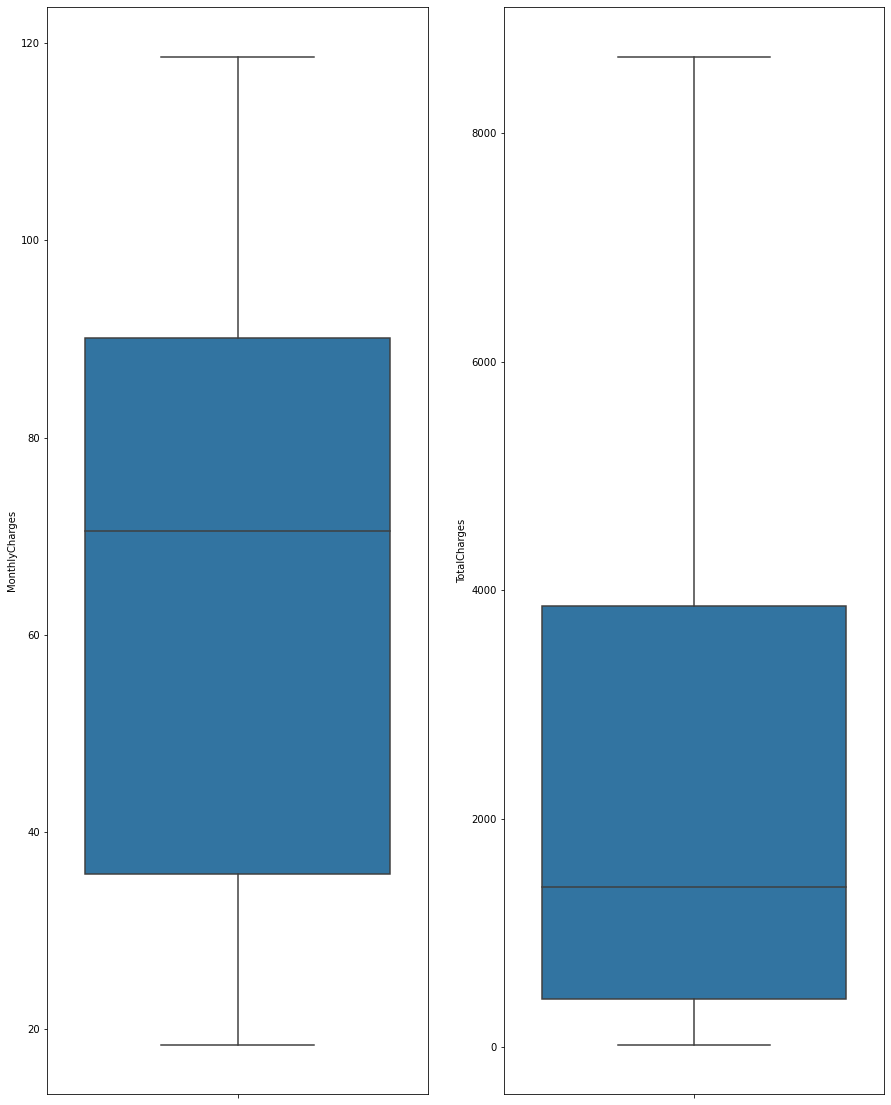

In [108]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,20))
index=0
ax=ax.flatten()
for col in train[numerical_col]:
    sns.boxplot(y=col,data=train,ax=ax[index])
    index+=1

### Handling missing values

In [33]:
train.isnull().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [40]:
train[train["OnlineBackup"].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,Male,0,False,False,16,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,Two year,False,Credit card (automatic),18.950001,326.799988,False
8191-XWSZG,Female,0,False,False,52,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,One year,False,Mailed check,20.650000,1022.950012,False
1680-VDCWW,Male,0,True,False,12,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,One year,False,Bank transfer (automatic),19.799999,202.250000,False
1066-JKSGK,Male,0,False,False,1,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,False,Mailed check,20.150000,20.150000,True
7310-EGVHZ,Male,0,False,False,1,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,False,Bank transfer (automatic),20.200001,20.200001,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765-MBQNU,Female,0,True,False,26,True,True,No,NaN,NaN,NaN,NaN,NaN,NaN,One year,False,Mailed check,26.000000,684.049988,False
3769-MHZNV,Female,0,True,True,33,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,Two year,False,Mailed check,20.100000,670.349976,False
3308-MHOOC,Male,0,False,True,1,True,False,No,NaN,NaN,NaN,NaN,NaN,NaN,Month-to-month,True,Mailed check,19.200001,19.200001,False
